# Setting Up All Architectures

Here, I want to setup the different architectures that will be implemented and trained on SEEG data to generate predictions of seizure.

We may assume the FFT data is averaged into their electrophysiological frequency bands:
* dalpha = 0-15
* beta = 15-30
* gamma = 30-90
* high = 90-200
* hfo = 200-500

or without high/hfo if we choose to just analyze the lower frequency range activities.

1. 2D CNN on images of FFT data projected into 2D space
2. 2D CNN+LSTM on images of FFT data projected onto 2D space
3. 2D CNN+biLSTM on images of FFT data projected onto 2D space
4. 2D CNN+biLSTM+mix on images of FFt data projected onto 2D space
5. 3D CNN on images of FFT data rendered in 3D mesh
6. 3D CNN+LSTM, 3D CNN+biLSTM, 3D CNN+biLSTM+mix on images of FFT data rendered in 3D mesh

In [11]:
import model.ieeg_cnn_rnn
import model.train

import processing.util as util

import time
import numpy as np
# np.random.seed(1234)
from functools import reduce
import math as m

# import DNN frameworks
import tensorflow as tf
import keras

# import high level optimizers, models and layers
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import InputLayer

# for CNN
from keras.layers import Conv2D, Conv3D, MaxPooling2D, GlobalAveragePooling2D
# for RNN
from keras.layers import LSTM

# for utility functionality
from keras.layers import Dense, Dropout, Flatten

from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding

# utility for datasets and training
# from keras.utils.training_utils import multi_gpu_model
from keras.datasets import imdb
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
# imports tensorflow
# from keras import backend as K

from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from keras.callbacks import TensorBoard

tbCallBack = TensorBoard(log_dir='Graph',
                         histogram_freq=10,
                         write_graph=True,
                         write_images=True)

# 1. Build and Prototype all 2D CNN Architectures

Here, I want to build all the models that will be trained on the FFT images dataset projected into 2D space.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        1184      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 64)        18496     
__________

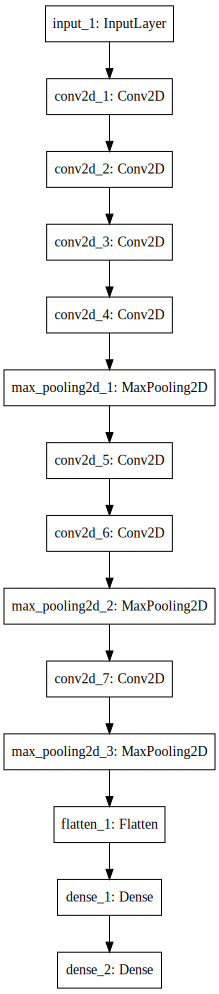

In [4]:
imsize=32
numfreqs = 4
numclasses = 2
ieegdnn = model.ieeg_cnn_rnn.IEEGdnn(imsize=imsize, 
                                     n_colors=numfreqs,
                                    num_classes=numclasses)

w_init = None
n_layers = (4,2,1)
poolsize = (2,2)
filtersize = (3,3)

size_fc = 1024
DROPOUT = False #True

# VGG-12 style later
vgg12cnn = ieegdnn._build_2dcnn(w_init=w_init, n_layers=n_layers, 
                              poolsize=poolsize, filter_size=filtersize)
vgg12cnn = ieegdnn._build_seq_output(vgg12cnn, size_fc, DROPOUT)
print(vgg12cnn.summary())

plot_model(vgg12cnn, to_file='vgg12_plot.png', show_shapes=True, show_layer_names=True)
SVG(model_to_dot(vgg12cnn).create(prog='dot', format='svg'))

/Users/adam2392/Documents/dnn-unsupervised/dnn/model/ieeg_cnn_rnn.py:193: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  model.add(Concatenate(convnets))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_22 (Merge)             (None, 640)               0         
_________________________________________________________________
reshape_21 (Reshape)         (None, 5, 128)            0         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 256)               263168    
_________________________________________________________________
dense_47 (Dense)             (None, 1024)              263168    
_________________________________________________________________
dense_48 (Dense)             (None, 2)                 2050      
Total params: 1,319,426
Trainable params: 1,319,426
Non-trainable params: 0
_________________________________________________________________
None


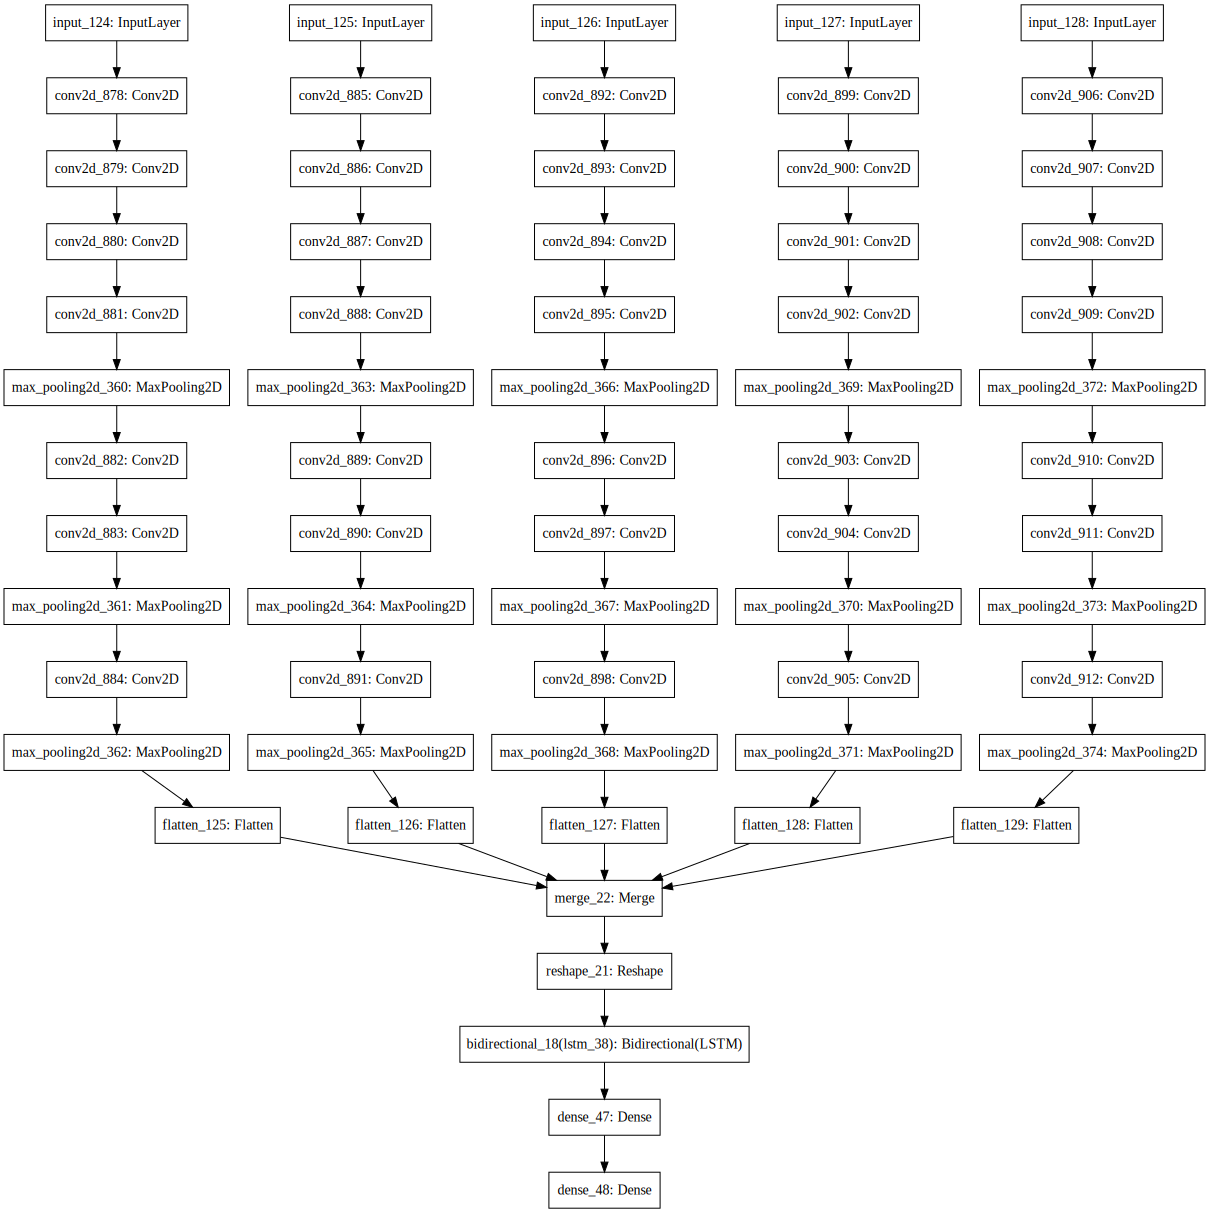

In [68]:
# load in CNN/LSTM
num_timewins = 5
size_mem = 128
size_fc = 1024
DROPOUT = False
cnn_lstm = ieegdnn.build_cnn_lstm(num_timewins=num_timewins, 
                                  size_mem=size_mem, 
                                  size_fc=size_fc, 
                                  BIDIRECT=True,
                                  DROPOUT=DROPOUT)

print(cnn_lstm.summary())
SVG(model_to_dot(cnn_lstm).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, 5, 128)            158208    
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 256)               263168    
_________________________________________________________________
dense_51 (Dense)             (None, 1024)              263168    
_________________________________________________________________
dense_52 (Dense)             (None, 2)                 2050      
Total params: 686,594
Trainable params: 686,594
Non-trainable params: 0
_________________________________________________________________
None


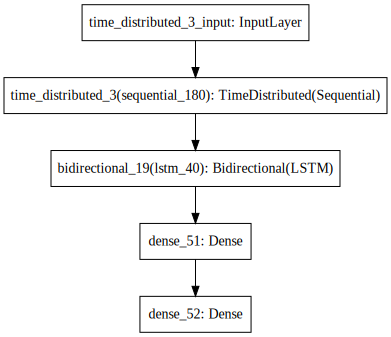

In [71]:
cnn_same_lstm = ieegdnn.build_same_cnn_lstm(num_timewins=num_timewins, 
                                  size_mem=size_mem, 
                                  size_fc=size_fc,
                                  BIDIRECT=True,
                                  DROPOUT=DROPOUT)

print(cnn_same_lstm.summary())
SVG(model_to_dot(cnn_same_lstm).create(prog='dot', format='svg'))

In [37]:
cnn_lstm_mix = ieegdnn.build_cnn_lstm_mix(num_timewins=num_timewins, 
                                  size_mem=size_mem, 
                                  size_fc=size_fc, 
                                  BIDIRECT=True,
                                  DROPOUT=DROPOUT)

print(cnn_lstm_mix.get_shape)
# print(cnn_lstm_mix.summary())
# SVG(model_to_dot(cnn_lstm_mix).create(prog='dot', format='svg'))

/Users/adam2392/Documents/dnn-unsupervised/dnn/model/ieeg_cnn_rnn.py:225: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  model.add(Merge(convnets, mode='concat'))


<bound method Tensor.get_shape of <tf.Tensor 'lstm_16/TensorArrayReadV3:0' shape=(?, 128) dtype=float32>>
<bound method Tensor.get_shape of <tf.Tensor 'flatten_92/Reshape:0' shape=(?, ?) dtype=float32>>
<bound method Tensor.get_shape of <tf.Tensor 'concatenate_5/concat:0' shape=(?, ?) dtype=float32>>
<bound method Tensor.get_shape of <tf.Tensor 'dense_32/Softmax:0' shape=(?, 2) dtype=float32>>


# 2. Building Architectures for 3D CNN

Build the CNN, CNN+LSTM, CNN+BidirectLSTM, CNN+BidirectLSTM+mix

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 32, 4)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 30, 30, 30, 32)    3488      
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 28, 28, 28, 32)    27680     
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 26, 26, 26, 32)    27680     
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 24, 24, 24, 32)    27680     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 12, 12, 12, 32)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 10, 10, 10, 64)    55360     
__________

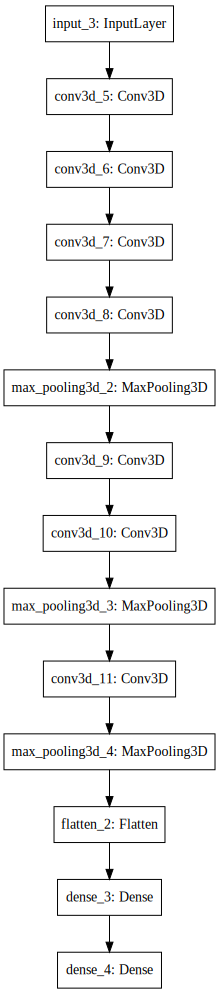

In [6]:
w_init = None
n_layers = (4,2,1)
poolsize = (2,2,2)
filtersize = (3,3,3)
size_fc = 1024
DROPOUT = False #True

# VGG-12 style later
vgg12cnn = ieegdnn._build_3dcnn(w_init=w_init, n_layers=n_layers, 
                              poolsize=poolsize, filter_size=filtersize)
vgg12cnn = ieegdnn._build_seq_output(vgg12cnn, size_fc, DROPOUT)
print(vgg12cnn.summary())
SVG(model_to_dot(vgg12cnn).create(prog='dot', format='svg'))

In [16]:
# load in CNN/LSTM
num_timewins = 5
size_mem = 128
size_fc = 1024
DROPOUT = False
# code up 3D CNN+LSTM, CNN+LSTMmix and get outputs
cnn_same_lstm = ieegdnn.build_same_cnn_lstm(num_timewins=num_timewins, 
                                  size_mem=size_mem, 
                                  size_fc=size_fc,
                                  dim=3,
                                  BIDIRECT=True,
                                  DROPOUT=DROPOUT)

print(cnn_same_lstm.summary())
SVG(model_to_dot(cnn_same_lstm).create(prog='dot', format='svg'))

cnn_lstm_mix = ieegdnn.build_cnn_lstm_mix(num_timewins=num_timewins, 
                                  size_mem=size_mem, 
                                  size_fc=size_fc, 
                                  dim=3,
                                  BIDIRECT=True,
                                  DROPOUT=DROPOUT)

print(type(cnn_lstm_mix))
print


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, 5, 128)            473856    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              263168    
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 2050      
Total params: 1,002,242
Trainable params: 1,002,242
Non-trainable params: 0
_________________________________________________________________
None


/Users/adam2392/Documents/dnn-unsupervised/dnn/model/ieeg_cnn_rnn.py:296: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  num_cnn_features = convnets[0].output_shape[1]


<class 'keras.engine.training.Model'>


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 32, 32, 32, 4 0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 32, 32, 32, 4 0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 32, 32, 32, 4 0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 32, 32, 32, 4 0                                            
__________________________________________________________________________________________________
input_19 (

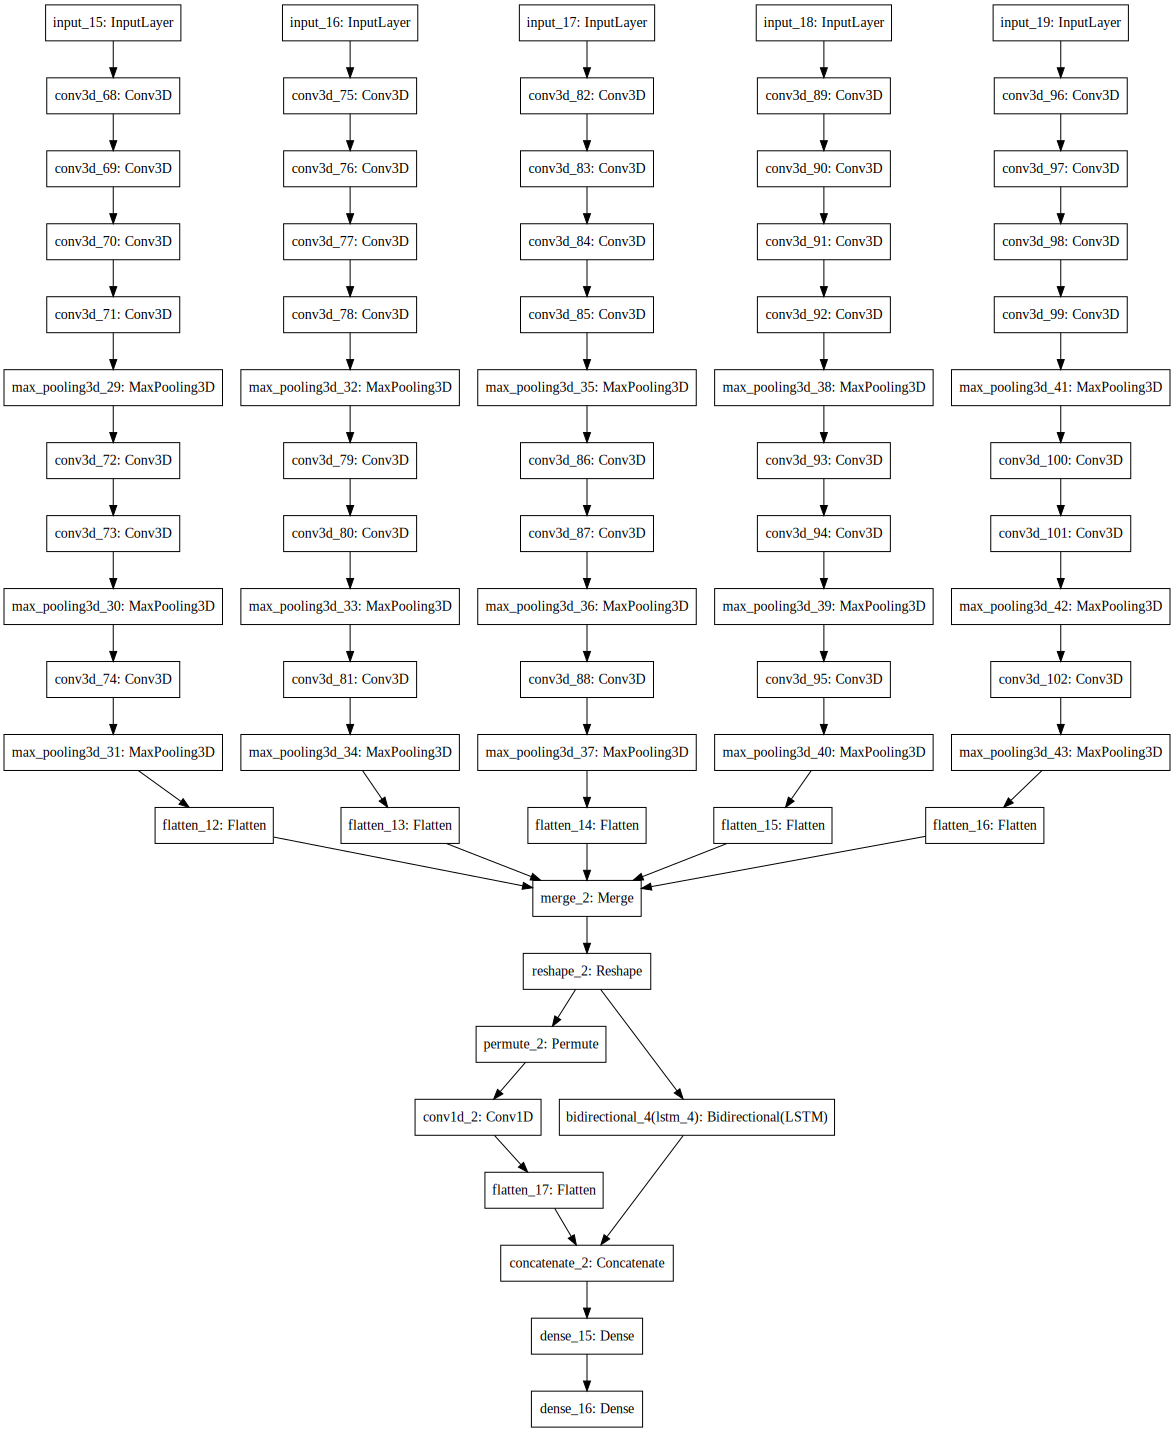

In [18]:
print(cnn_lstm_mix.summary())
SVG(model_to_dot(cnn_lstm_mix).create(prog='dot', format='svg'))


# 3. Build Up Some PreBuilt Keras Models

Import VGG and certain architectures that already have pretrained weights.

I will test say... VGG16, InceptionV3 and Xception

In [23]:
from keras.applications import VGG16, VGG19, MobileNet, Xception, InceptionV3
from keras.models import Model

In [15]:
# create the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(200, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [19]:
# create the base pre-trained model
base_model = VGG19(weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(200, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

print(model.summary())

80142336/80134624 [==============================] - 19s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_poo

In [22]:
# create the base pre-trained model
base_model = MobileNet(input_shape=(128,128,3), weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(200, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

print(model.summary())

17227776/17225924 [==============================] - 4s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_r

In [24]:
# create the base pre-trained model
base_model = Xception(weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(200, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

print(model.summary())

83689472/83683744 [==============================] - 23s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_22[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________

In [26]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(200, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

print(model.summary())

87916544/87910968 [==============================] - 53s 1us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, None, None, 3 864         input_23[0][0]                   
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, None, None, 3 96          conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_5[0][0]      
___________________________________________